## 파일 구조

```bash
├── Data
│   ├── 2015
│   │    ├── Biometrika
│   │    │    ├── Biometrika_Train.hdf5
│   │    │    └── Biometrika_Test.hdf5
│   │    ├── CrossMatch
│   │    │    └── CrossMatch_data.pkl
│   │    ├── DigitalPersona
│   │    │    └── DigitalPersona_data.pkl
│   │    ├── HiScan
│   │    │    └── HiScan_data.pkl
│   │    └── GreenBit
│   │         └── GreenBit_data.hdf5
│   └── 2019
│   
└── Code
    ├── main.ipynb
    ├── evaluation.py
    ├── datasets
    │    ├── augment.py
    │    ├── data_loading.py
    │    ├── dataset.py
    │    └── transforms.py
    ├── metric
    │    └── metric.py
    ├── model
    │    ├── model.py
    │    ├── modules.py
    │    └── pos_embed.py
    ├── opt
    │    ├── base_opt.py
    │    └── Config.py
    └── utils
         ├── check_TF.py
         ├── oneEpoch.py
         ├── scheduler.py
         └── visualization.py

``` 

## import library

In [6]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
from PIL import Image
import cv2
import h5py
import pickle

import matplotlib.pyplot as plt

### dataset, year, sensor 선택
- 2015
    - GreenBit 
    - Biometrika 
    - CrossMatch 
    - HiScan
    - DigitalPersona 
- 2019
    - GreenBit
    - DigitalPersona
    - Orcathus

In [67]:
year = '2015'
sensor = 'DigitalPersona'
data_root = './Data/'

### dataset loading

In [68]:
from datasets.data_loading import data_loading

Data = data_loading(year, sensor, data_root, phase='train')


x_train, x_test, x_target, x_label
./Data/2015/GreenBit/GreenBit_data.hdf5
Path: ./Data/2015/GreenBit/GreenBit_data.hdf5
hdf5
./Data/2015/GreenBit/GreenBit_data.hdf5
---finish---
# of x_train: 15968
# of x_target: 15968
x_train.shape: (500, 500, 1)
-------------------------------------------
# of x_test: 2495
# of x_label: 2495
x_test.shape: (500, 500)


torch.Size([5, 1, 224, 224])


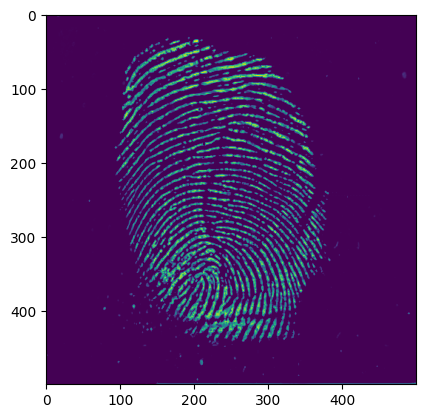

/tmp/ipykernel_2213584/3078510166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(a[i]).permute(1,2,0).clone().detach().numpy(), cmap='gray')


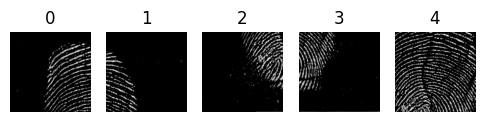

In [96]:
tt = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.FiveCrop(224),
                            transforms.Lambda(lambda crops: torch.stack([transforms.PILToTensor()(crop) for crop in crops])),
                            transforms.Normalize([0.8],[0.3])
                        ])
idx=2331
a = tt(np.abs((255-Data['x_test'][idx])/255.).astype(np.float32))
print(a.shape)

plt.imshow(((255-Data['x_test'][idx])/255.).astype(np.float32))
plt.show()

plt.figure(figsize=(6,4))
for i in range(len(a)):
    plt.subplot(1, 5, i+1)
    plt.imshow(torch.tensor(a[i]).permute(1,2,0).clone().detach().numpy(), cmap='gray')
    plt.title(f'{i}')
    plt.axis('off')
plt.show()




### Transform Data
- Crop 224x224

In [65]:
from datasets.transforms import FiveCrop

fivecrop = FiveCrop(sensor,crop_size=224)

Data = fivecrop.transforms(Data)

...Cropping x_train...


100%|████████████████████████████████████████████████████████████████████████████| 15968/15968 [00:30<00:00, 521.40it/s]


...Cropping x_test...


100%|██████████████████████████████████████████████████████████████████████████████| 2495/2495 [00:04<00:00, 524.51it/s]

x_train.shape: torch.Size([1, 224, 224])
x_test.shape: torch.Size([1, 224, 224])


### Check Croped image

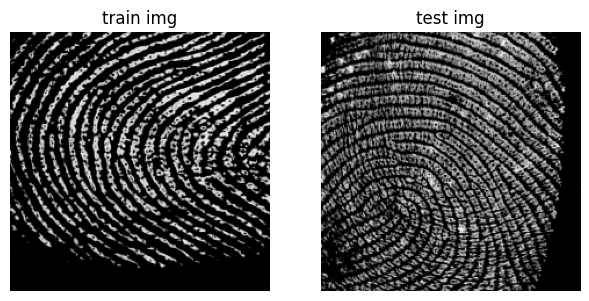

In [66]:
from utils.visualization import plot_cropped

plot_cropped(Data['x_train'], Data['x_test'])


### Hyperparameter Setting & Initialize Config
- ./utils/base_opt.py

In [49]:
from opt.base_opt import Opt
print(Opt)

Opt = {
    'gpu_id':0,         # 사용할 gpu 번호
    'img_size':224,     # 입력 image 크기 == crop 크기
    'in_chans': 1,      # image channel
    'depth':2,          # mhsa 반복 횟수
    'patch_size': 16,   # mhsa patch 크기
    'embed_dim': 32,    # mhsa embedding 크기
    'num_heads': 4,     # mhsa head 개수
    'batch_size':32,    
    'weight_decay':0.05,  
    'betas':(0.9,0.999),
    'criterion': nn.CrossEntropyLoss(),
    'optimizer':'AdamW',
    'scheduler':'CosineAnnealingWarmupRestarts',#'exp',#
    'max_lr':0.0005,                             # cosine 최대값
    'min_lr':5e-7,                               # cosine 최소값
    'gamma':0.8,                                 # exponential scheduler gamma
    'epochs':200,                                # total epoch
    'num_workers':8,                             # window에서 실행할 경우 0으로 변경
    'block_out_list': [32, 32, 32, 32, 32, 32],
    'down_list': [True, False, True, False, False, True],
    'block_mid_chan': 8,
    'loss_coef': [1,0.2],
    'transforms':['RandomRotate'], # RandomRotate, RandomErasing, empty,
    'use_scheduler':True
}


{'gpu_id': 1, 'img_size': 224, 'in_chans': 1, 'depth': 1, 'patch_size': 16, 'embed_dim': 96, 'num_heads': 4, 'batch_size': 32, 'weight_decay': 0.5, 'betas': (0.9, 0.85), 'criterion': CrossEntropyLoss(), 'optimizer': 'AdamW', 'step_size': 20, 'scheduler': 'CosineAnnealingWarmupRestarts', 'max_lr': 0.0005, 'min_lr': 5e-07, 'gamma': 0.8, 'epochs': 100, 'num_workers': 4, 'block_out_list': [32, 64, 128], 'down_list': [True, True, True], 'block_mid_chan': 64, 'loss_coef': [1, 0.2], 'transforms': [], 'use_scheduler': True}


In [50]:
from opt.Config import Config
from opt.base_opt import smallOpt


smallOpt['gpu_id'] = 0
print(smallOpt)
config = Config(opt=smallOpt)  # 위의 Opt 변경 시 parameter로 넣어주세요.


{'gpu_id': 0, 'img_size': 224, 'in_chans': 1, 'depth': 2, 'patch_size': 16, 'embed_dim': 32, 'num_heads': 4, 'batch_size': 32, 'weight_decay': 0.05, 'betas': (0.9, 0.999), 'criterion': CrossEntropyLoss(), 'optimizer': 'AdamW', 'scheduler': 'CosineAnnealingWarmupRestarts', 'max_lr': 0.0005, 'min_lr': 5e-07, 'gamma': 0.8, 'epochs': 200, 'num_workers': 8, 'block_out_list': [32, 32, 32, 32, 32, 32], 'down_list': [True, False, True, False, False, True], 'block_mid_chan': 16, 'loss_coef': [1, 0.2], 'transforms': ['RandomRotate'], 'use_scheduler': True}


### model architecture

In [51]:
from torchinfo import summary
config.load_model()
summary(config.model, input_size=(3,1,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [3, 2]                    6,336
├─PatchEmbed: 1-1                        [3, 196, 32]              --
│    └─Conv2d: 2-1                       [3, 32, 14, 14]           8,224
│    └─Identity: 2-2                     [3, 196, 32]              --
├─Sequential: 1-2                        [3, 197, 32]              --
│    └─MSA: 2-3                          [3, 197, 32]              --
│    │    └─Linear: 3-1                  [3, 197, 96]              3,168
│    │    └─Identity: 3-2                [3, 4, 197, 8]            --
│    │    └─Identity: 3-3                [3, 4, 197, 8]            --
│    │    └─Dropout: 3-4                 [3, 4, 197, 197]          --
│    │    └─Linear: 3-5                  [3, 197, 32]              1,056
│    │    └─Dropout: 3-6                 [3, 197, 32]              --
│    └─MSA: 2-4                          [3, 197, 32]              --
│  

### CustomDataset & DataLoader

In [52]:
# from datasets.dataset import CustomDataset, CustomTransforms


############ CustomTransforms: RandomRotation ################

# train_dataset = CustomDataset(phase='train', Data=Data, transforms=CustomTransforms)
# train_dataloader = DataLoader(train_dataset,batch_size=config.batch_size,shuffle=True,num_workers=config.num_workers)

# val_dataset = CustomDataset(phase='val', Data=Data, transforms=CustomTransforms)
# val_dataloader = DataLoader(val_dataset,batch_size=config.batch_size,shuffle=True,num_workers=config.num_workers)

from datasets.dataset import load_dataloader
train_dataloader = load_dataloader(config, phase='train', Data=Data)
val_dataloader = load_dataloader(config, phase='val', Data=Data)


### ACE 계산을 위해 True, False 계산

In [53]:
from utils.check_TF import check_TF

Data = check_TF(Data)


# of x_target t_num: 8000
# of x_target f_num: 9600
# of x_label t_num: 990
# of x_label f_num: 1088


### Train history

In [60]:
history = {
        'train':{
            'learning_rate':[],
            'acc':[],
            'loss':[],
            'ace':[]
        },
        'val':{
            'acc':[],
            'loss':[],
            'ace':[]
        },
        'best':{
            'acc':0,
            'ace':999,
            'epoch_acc':None,
            'epoch_ace':None,
            'state':None
        },
        'model_save':False,              # 학습결과 저장 여부
        'result_name':'01',              # 실험 이름(저장결과 폴더 생성)
        'save_dir':'./result',           # 학습결과 저장 폴더 위치
        'save_name':f'{sensor}_result.pt'# 학습결과 저장 파일 이름
    }

### Train & eval

In [61]:
from torchmetrics.functional.classification import binary_stat_scores
from utils.oneEpoch import train_one, val_one
import os
from copy import deepcopy

################## model 불러오기 (초기화) ##################
config.load_model() 
config.model.to(config.device)


################# Train & Eval #############################
for epoch in range(config.epochs):
    for p in ['train','val']:
        if p=='train':
            total_FP = 0
            total_FN = 0
            total_correct = 0
            total_att_correct = 0
            total_num = 0
            total_loss = 0
            
            
            config.model.train()
            
            for i,(img,label) in enumerate(train_dataloader):
                correct=0
                total = 0
                loss = 0
                acc = 0
                EL = 0
                EF = 0
                
                img = img.to(config.device)
                label = label.to(config.device)
                correct, loss, total, FP, FN, att_correct = train_one(img,label,config.model,config.criterion,config.optimizer, binary_stat_scores, config.loss_coef)
                total_att_correct += att_correct
                total_FP += FP
                total_FN += FN
                total_correct += correct
                total_num += total
                total_loss += loss
            
            epoch_loss = total_loss / total_num
            acc = 100 * total_correct / total_num
            ace = ((total_FP/Data['x_target_f_num'])*100 + (total_FN/Data['x_target_t_num'])*100)/2
            att_acc = 100 * total_att_correct / total_num
            if config.use_scheduler:
                train_text = f'Train | Epoch: [{epoch+1}/{config.epochs}] Acc: [{acc:.3f}%] Loss: [{epoch_loss:.5f}] ACE: [{ace:.2f}] AttAcc: [{att_acc:.3f}%] LR: [{config.scheduler.get_last_lr()[0]}]'
            else:
                train_text = f'Train | Epoch: [{epoch+1}/{config.epochs}] Acc: [{acc:.3f}%] Loss: [{epoch_loss:.5f}] ACE: [{ace:.2f}] AttAcc: [{att_acc:.3f}%]'
            print('='*len(train_text))
            print(train_text)
            
            if config.use_scheduler:
                config.scheduler.step(epoch)
            history['train']['learning_rate'].append(config.scheduler.get_last_lr())
            history['train']['acc'].append(acc)
            history['train']['loss'].append(epoch_loss)
            history['train']['ace'].append(ace.cpu())
            
        elif p=='val':
            total_correct = 0
            total_num = 0
            total_loss = 0
            total_FP = 0
            total_FN = 0
            total_en_FP = 0
            total_en_FN = 0
            total_att_correct = 0
            total_en_correct = 0
            
            config.model.eval()
            with torch.no_grad():
                for i,(img,label) in enumerate(val_dataloader):
                    correct = 0
                    total = 0
                    loss = 0
                    ace = 0
                    img = img.to(config.device)
                    label = label.to(config.device)
                    correct, loss, total, FP, FN, att_correct = val_one(img,label,config.model,config.criterion, binary_stat_scores)
                    total_att_correct += att_correct
                    total_correct += correct
                    total_num += total
                    total_loss += loss
                    total_FP += FP
                    total_FN += FN
                    
                epoch_loss = total_loss / total_num
                acc = 100 * total_correct / total_num
                ace = ((total_FP/Data['x_label_f_num'])*100 + (total_FN/Data['x_label_t_num'])*100)/2
                history['val']['acc'].append(acc)
                history['val']['loss'].append(epoch_loss)
                history['val']['ace'].append(ace.cpu())
                att_acc = 100 * total_att_correct / total_num
                eval_text = f'Eval  | Epoch: [{epoch+1}/{config.epochs}] Acc: [{acc:.3f}%] Loss: [{epoch_loss:.5f}] ACE: [{ace:.2f}] AttAcc: [{att_acc:.3f}%]'
                print(eval_text)
                print('='*len(train_text))
                if acc > history['best']['acc']:
                    history['best']['acc'] = acc
                    history['best']['epoch_acc'] = epoch
                    history['best']['state'] = deepcopy(config.model.state_dict())
                if ace < history['best']['ace']:
                    history['best']['epoch_ace'] = epoch
                    history['best']['ace'] = ace
                
print(f'Result | epoch: [{history["best"]["epoch_acc"]+1}] Best Acc: [{history["best"]["acc"]:.3f}%] | ace_epoch: [{history["best"]["epoch_ace"]+1}] Best ACE: [{history["best"]["ace"]:.2f}]')

if history['model_save']:
    if os.path.isdir(history['save_dir']):
        path = history['save_dir'] + '/' + history['model_save_name']
        torch.save(history['best']['state'], path)
    else:
        os.mkdir(history['save_dir'])
        path = history['save_dir'] + '/' + history['model_save_name']
        torch.save(history['best']['state'], path)

Train | Epoch: [1/200] Acc: [85.045%] Loss: [0.01410] ACE: [15.35] AttAcc: [68.352%] LR: [5.308110377052682e-07]
Eval  | Epoch: [1/200] Acc: [89.702%] Loss: [0.01220] ACE: [10.31] AttAcc: [72.955%]
Train | Epoch: [2/200] Acc: [90.568%] Loss: [0.01004] ACE: [9.61] AttAcc: [79.256%] LR: [0.0005]
Eval  | Epoch: [2/200] Acc: [81.665%] Loss: [0.02203] ACE: [17.69] AttAcc: [79.500%]
Train | Epoch: [3/200] Acc: [92.011%] Loss: [0.00891] ACE: [8.13] AttAcc: [81.205%] LR: [0.0004999691889622948]
Eval  | Epoch: [3/200] Acc: [90.568%] Loss: [0.01475] ACE: [9.80] AttAcc: [77.093%]
Train | Epoch: [4/200] Acc: [92.938%] Loss: [0.00825] ACE: [7.17] AttAcc: [81.688%] LR: [0.0004998767634513414]
Eval  | Epoch: [4/200] Acc: [88.210%] Loss: [0.01393] ACE: [11.45] AttAcc: [81.328%]
Train | Epoch: [5/200] Acc: [93.500%] Loss: [0.00774] ACE: [6.62] AttAcc: [82.693%] LR: [0.000499722746271752]
Eval  | Epoch: [5/200] Acc: [93.648%] Loss: [0.00925] ACE: [6.45] AttAcc: [80.606%]
Train | Epoch: [6/200] Acc: [93.

In [62]:
print(f'Result | epoch: [{history["best"]["epoch_acc"]+1}] Best Acc: [{history["best"]["acc"]:.3f}%] | ace_epoch: [{history["best"]["epoch_ace"]+1}] Best ACE: [{history["best"]["ace"]:.2f}]')

Result | epoch: [129] Best Acc: [97.305%] | ace_epoch: [129] Best ACE: [2.71]


In [43]:
sensor, year

('GreenBit', '2019')

In [44]:
#torch.save(history['best']['state'], f'./result/{year}{sensor}_best_acc.pt')

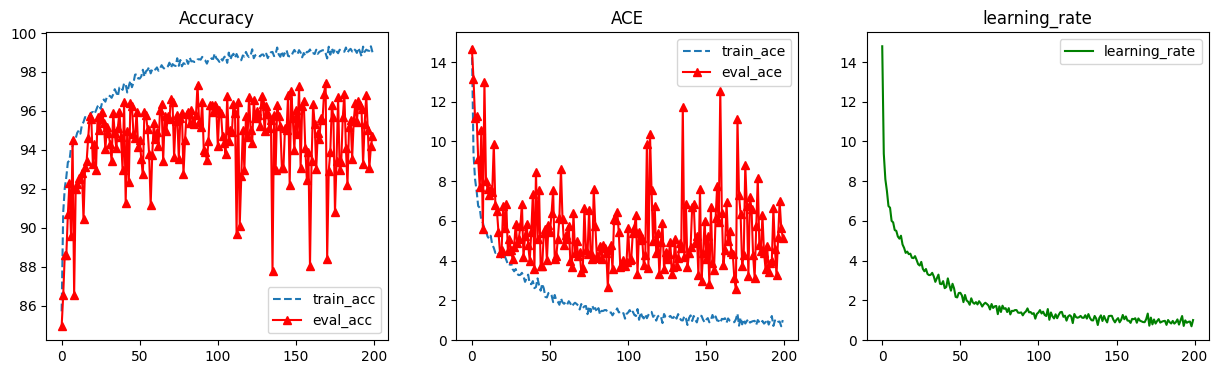

In [29]:
from utils.visualization import plot_history

plot_history(history)

index: 332
inference time: 12.753
output: tensor([[-6.6641,  6.3394]], device='cuda:1')


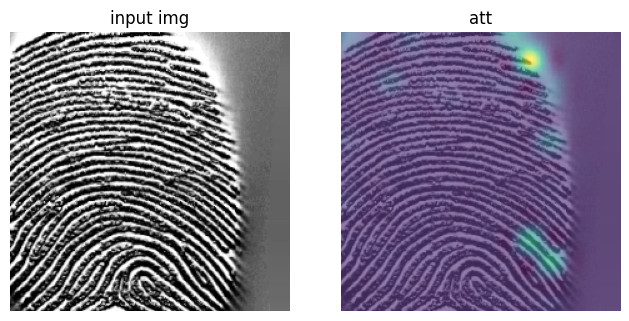

label: 1
index: 228
inference time: 10.046
output: tensor([[-11.4325,  10.9813]], device='cuda:1')


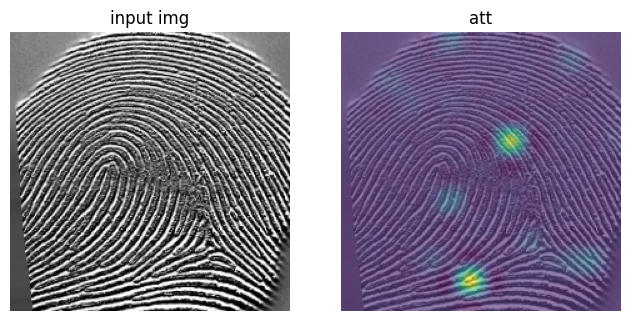

label: 1
index: 1441
inference time: 11.173
output: tensor([[-7.1121,  6.8150]], device='cuda:1')


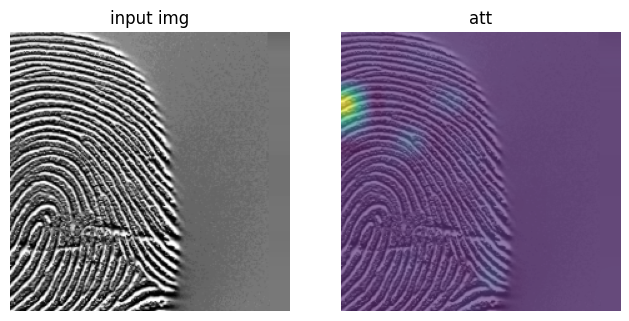

label: 1
index: 1983
inference time: 8.630
output: tensor([[ 8.4909, -8.7557]], device='cuda:1')


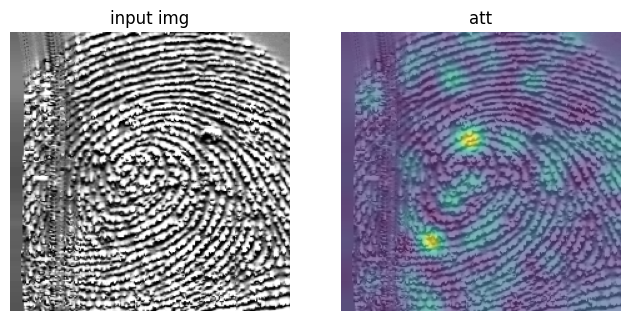

label: 0
index: 1680
inference time: 8.438
output: tensor([[-3.9741,  3.7926]], device='cuda:1')


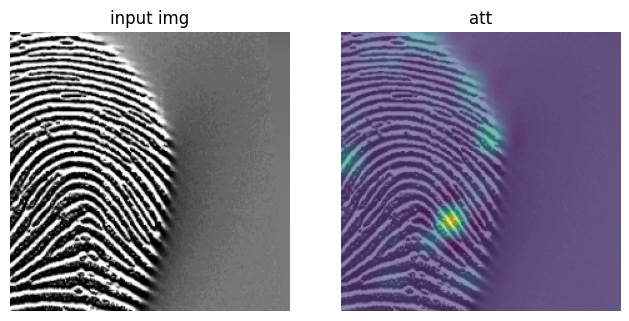

label: 1


In [32]:
from utils.visualization import plot_att
import random

for _ in range(5):
    idx = random.randrange(len(Data['x_label']))
    print(f'index: {idx}')
    plot_att(config, Data['x_test'][idx], history['best']['state'])
    print(f'label: {Data["x_label"][idx]}')
    print("="*88)

In [ ]:
year = '2015'
sensor = 'GreenBit'
data_root = '../Data/'

In [ ]:
## inference time 측정하는 code 작성

from evaluation import time_evaluation


            